In [4]:
%pip install -q python-binance pandas numpy python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
load_dotenv()                                    # reads .env

import os, math, time, pandas as pd, numpy as np
from binance import Client
from datetime import datetime, timezone
from datetime import datetime, timedelta, timezone

import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import os

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from IPython.display import display


API_KEY = os.getenv("BINANCE_SUB_KEY")
API_SEC = os.getenv("BINANCE_SUB_SEC")

if not API_KEY or not API_SEC:
    raise RuntimeError("API credentials not found!")

client = Client(API_KEY, API_SEC, tld="com", testnet=False)   # sub-account key

# ▒▒▒ 2. Strategy logic (unchanged from earlier posts) ▒▒▒
def filt9x(a, s, i, fh):
    m2=[0,1,3,6,10,15,21,28,36][i-1]; m3=[0,0,1,4,10,20,35,56,84][i-1]
    m4=[0,0,0,1,5,15,35,70,126][i-1]; m5=[0,0,0,0,1,6,21,56,126][i-1]
    m6=[0,0,0,0,0,1,7,28,84][i-1];  m7=[0,0,0,0,0,0,1,8,36][i-1]
    m8=[0,0,0,0,0,0,0,1,9][i-1];   m9=[0,0,0,0,0,0,0,0,1][i-1]
    x=1-a; f=(a**i)*s
    if len(fh)>=1: f+=i*x*fh[-1]
    if len(fh)>=2: f-=m2*(x**2)*fh[-2]
    if len(fh)>=3: f+=m3*(x**3)*fh[-3]
    if len(fh)>=4: f-=m4*(x**4)*fh[-4]
    if len(fh)>=5: f+=m5*(x**5)*fh[-5]
    if len(fh)>=6: f-=m6*(x**6)*fh[-6]
    if len(fh)>=7: f+=m7*(x**7)*fh[-7]
    if len(fh)>=8: f-=m8*(x**8)*fh[-8]
    if len(fh)>=9: f+=m9*(x**9)*fh[-9]
    return f

def n_pole(series, per, N=4):
    beta=(1-math.cos(4*math.asin(1)/per))/(math.pow(1.414,2/N)-1)
    a=-beta+math.sqrt(beta*beta+2*beta)
    fh, out=[], np.zeros_like(series)
    for idx,s in enumerate(series):
        fn=filt9x(a,s,N,fh)
        out[idx]=fn; fh.append(fn)
        if len(fh)>9: fh.pop(0)
    return out

def stoch_rsi(close, rsi_len=14, st_len=14, k_len=3, d_len=3):
    rs = pd.Series(close).diff().rename("delta")
    up, dn = rs.clip(lower=0), -rs.clip(upper=0)
    roll_up  = up.rolling(rsi_len).mean()
    roll_dn  = dn.rolling(rsi_len).mean()
    rsi      = 100 - 100/(1+roll_up/roll_dn)
    stoch    = (rsi - rsi.rolling(st_len).min()) / \
               (rsi.rolling(st_len).max() - rsi.rolling(st_len).min())
    k = stoch.rolling(k_len).mean()*100
    d = k.rolling(d_len).mean()
    return k.values, d.values

def gaussian_channel_strategy(df,
                               poles=4,
                               per=144,
                               mult=1.414,
                               high_thr=80,
                               low_thr=20):
    src   = df[['high', 'low', 'close']].mean(axis=1).values
    close = df['close'].values

    mid   = n_pole(src, per, N=poles)
    tr    = np.maximum(df['high']-df['low'],
              np.maximum(abs(df['high']-df['close'].shift()),
                         abs(df['low'] -df['close'].shift()))).fillna(0).values
    tr_f  = n_pole(tr, per, N=poles)
    hband = mid + tr_f * mult
    lband = mid - tr_f * mult

    k, d  = stoch_rsi(close)
    gauss_green = mid > np.roll(mid, 1)
    price_above = close > hband
    both_high   = (k > high_thr) & (d > high_thr)
    both_low    = (k < low_thr)  & (d < low_thr)
    k_gt_d      = k > d
    enter_long  = gauss_green & price_above & (both_high | both_low) & k_gt_d
    exit_long   = (close < hband) & np.roll(close >= hband, 1)

    return pd.DataFrame({
        "mid": mid,
        "hband": hband,
        "lband": lband,
        "enter_long": enter_long,
        "exit_long": exit_long
    }, index=df.index)



#Extract data from binance
def fetch_klines(symbol, interval, start_dt, end_dt):
    """
    Stream klines in 1 000-row chunks and return a tidy OHLCV dataframe.
    """
    df_all = []
    while start_dt < end_dt:
        kl = client.get_klines(symbol=symbol,
                               interval=interval,
                               startTime=int(start_dt.timestamp() * 1000),
                               endTime  =int(end_dt.timestamp() * 1000),
                               limit=1000)
        if not kl:
            break

        # 12 columns exactly as Binance returns them
        cols = ("open_time","open","high","low","close","volume",
                "close_time","quote_asset_volume","trades",
                "taker_buy_base","taker_buy_quote","ignore")

        df = pd.DataFrame(kl, columns=cols).astype(float)
        df_all.append(df)

        # advance cursor by the last bar’s close time + 1 ms
        last_close_ms = df["close_time"].iloc[-1]
        start_dt = datetime.fromtimestamp(last_close_ms / 1000 + 0.001,
                                          tz=timezone.utc)

    df = pd.concat(df_all, ignore_index=True)

    # index & trim to OHLCV we actually need
    df["open_time"] = pd.to_datetime(df.open_time, unit='ms', utc=True)
    df.set_index("open_time", inplace=True)
    return df[["open","high","low","close","volume"]]

# ────────────────────────────────────────────────────────────────
def get_realtime_signal(strategy_function,
                        strategy_params,
                        symbol="BTCUSDT",
                        interval="1d",
                        start_date=None):
    end_dt = datetime.now(tz=timezone.utc)
    if start_date is None:
        start_dt = end_dt - timedelta(days=400)
    else:
        start_dt = datetime.fromisoformat(start_date).replace(tzinfo=timezone.utc)

    df = fetch_klines(symbol, interval, start_dt, end_dt)

    # Run the selected strategy with its own parameters
    sig = strategy_function(df, **strategy_params)
    sig["price"] = df["close"]

    trades, in_pos = [], None
    for ts, row in sig.iterrows():
        if row.enter_long and in_pos is None:
            in_pos = {"enter_position_date": ts, "enter_position_price": row.price}
        elif row.exit_long and in_pos is not None:
            exit_px = row.price
            entry_px = in_pos["enter_position_price"]
            days = (ts - in_pos["enter_position_date"]).days
            trades.append(dict(
                enter_position_date = in_pos["enter_position_date"],
                enter_position_price= entry_px,
                exit_position_date  = ts,
                exit_position_price = exit_px,
                q_days_of_position  = days,
                price_difference_of_position = round(exit_px - entry_px, 2),
                percentage_of_position = round(exit_px / entry_px - 1, 4)
            ))
            in_pos = None

    trades_df = pd.DataFrame(trades).sort_values("enter_position_date")

    last = sig.iloc[-1]
    action = "OPEN_LONG"  if last.enter_long else \
             "CLOSE_LONG" if last.exit_long  else "WAIT"

    return {
        "strategy": strategy_function.__name__.replace("_strategy", "").replace("_", " ").title(),
        "symbol": symbol,
        "interval": interval,
        "signal": action,
        "df": df,
        "signals_df": sig,
        "trades_df": trades_df
    }



#### ANALYSIS
def analyze_trades(trades_df, symbol=None, strategy=None, interval=None, df_prices=None):
    if trades_df.empty or df_prices is None or df_prices.empty:
        print("⚠️ Missing trades or price data.")
        return

    now = datetime.utcnow()
    now_str = now.strftime("%Y-%m-%d %H:%M UTC")
    filename_str = now.strftime("%Y%m%d")
    title = f"{strategy} on {symbol} ({interval})"
    
    os.makedirs("pdf", exist_ok=True)
    file_name = f"pdf/{strategy.replace(' ', '')}_{symbol}_{interval}_{filename_str}.pdf"

    print(f"\n📈 Strategy Analysis for {title} — {now_str}\n")

    # Strategy statistics
    cumulative_return = np.prod(1 + trades_df["percentage_of_position"]) - 1
    wins = trades_df[trades_df["percentage_of_position"] > 0]
    losses = trades_df[trades_df["percentage_of_position"] <= 0]

    summary_df = pd.DataFrame({
        "Metric": [
            "Total Trades",
            "Avg Holding Period (days)",
            "Max Holding Period (days)",
            "Min Holding Period (days)",
            "Cumulative Return (%)",
            "Max Gain (%)",
            "Max Loss (%)",
            "Win Count",
            "Avg Win (%)",
            "Max Win (%)",
            "Min Win (%)",
            "Loss Count",
            "Avg Loss (%)",
            "Max Loss (%)",
            "Min Loss (%)"
        ],
        "Value": [
            len(trades_df),
            round(trades_df["q_days_of_position"].mean(), 2),
            trades_df["q_days_of_position"].max(),
            trades_df["q_days_of_position"].min(),
            round(cumulative_return * 100, 2),
            round(trades_df["percentage_of_position"].max() * 100, 2),
            round(trades_df["percentage_of_position"].min() * 100, 2),
            len(wins),
            round(wins["percentage_of_position"].mean() * 100, 2) if not wins.empty else 0,
            round(wins["percentage_of_position"].max() * 100, 2) if not wins.empty else 0,
            round(wins["percentage_of_position"].min() * 100, 2) if not wins.empty else 0,
            len(losses),
            round(losses["percentage_of_position"].mean() * 100, 2) if not losses.empty else 0,
            round(losses["percentage_of_position"].max() * 100, 2) if not losses.empty else 0,
            round(losses["percentage_of_position"].min() * 100, 2) if not losses.empty else 0,
        ]
    })

    # Buy & Hold vs Strategy comparison
    start_price = df_prices["close"].iloc[0]
    end_price = df_prices["close"].iloc[-1]
    price_return = (end_price / start_price) - 1
    initial_capital = 100
    hold_final_value = initial_capital * (1 + price_return)
    strategy_final_value = initial_capital * (1 + cumulative_return)

    comparison_df = pd.DataFrame({
        "Metric": [
            "Start Price",
            "Current Price",
            "Price Return (%)",
            "Strategy Cumulative Return (%)",
            "Hold Final Value ($100 start)",
            "Strategy Final Value ($100 start)"
        ],
        "Value": [
            round(start_price, 2),
            round(end_price, 2),
            round(price_return * 100, 2),
            round(cumulative_return * 100, 2),
            round(hold_final_value, 2),
            round(strategy_final_value, 2)
        ]
    })

    # Display tables
    #display(summary_df)
    #display(comparison_df)

    with PdfPages(file_name) as pdf:
        # Summary table
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('off')
        table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax.set_title(f"Strategy Summary — {title}", fontsize=14)
        pdf.savefig(fig)
        plt.show()

        # Comparison table
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.axis('off')
        table = ax.table(cellText=comparison_df.values, colLabels=comparison_df.columns,
                         cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        ax.set_title(f"Buy & Hold vs Strategy — {title}", fontsize=14)
        pdf.savefig(fig)
        plt.show()

        # Histogram: % Return
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(trades_df["percentage_of_position"], bins=10, kde=False, color="blue", ax=ax)
        ax.set_title(f"% Return of All Trades — {title}")
        ax.set_xlabel("Percentage Return")
        ax.set_ylabel("Frequency")
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                            ha='center', va='bottom')
        pdf.savefig(fig)
        plt.show()

        # Histogram: Holding Period
        fig, ax = plt.subplots(figsize=(10, 5))
        sns.histplot(trades_df["q_days_of_position"], bins=10, kde=False, color="gray", ax=ax)
        ax.set_title(f"Holding Period (Days) — {title}")
        ax.set_xlabel("Days")
        ax.set_ylabel("Frequency")
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                            ha='center', va='bottom')
        pdf.savefig(fig)
        plt.show()

        # Win vs Loss Histograms
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        if not wins.empty:
            ax = axs[0]
            sns.histplot(wins["percentage_of_position"], bins=5, kde=False, color="green", ax=ax)
            ax.set_title(f"Win Trades — {strategy}")
            ax.set_xlabel("Percentage Return")
            for p in ax.patches:
                height = p.get_height()
                if height > 0:
                    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                                ha='center', va='bottom')
        else:
            axs[0].set_title("No Win Trades")

        if not losses.empty:
            ax = axs[1]
            sns.histplot(losses["percentage_of_position"], bins=5, kde=False, color="red", ax=ax)
            ax.set_title(f"Loss Trades — {strategy}")
            ax.set_xlabel("Percentage Return")
            for p in ax.patches:
                height = p.get_height()
                if height > 0:
                    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                                ha='center', va='bottom')
        else:
            axs[1].set_title("No Loss Trades")

        plt.tight_layout()
        pdf.savefig(fig)
        plt.show()

        # Cumulative return over time
        cumulative = (1 + trades_df["percentage_of_position"]).cumprod() * 100
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(trades_df["exit_position_date"], cumulative, marker='o', linestyle='-')
        ax.set_title(f"Cumulative Return Over Time — {title}")
        ax.set_xlabel("Exit Date")
        ax.set_ylabel("Cumulative Return (%)")
        ax.grid(True)
        for i, (x, y) in enumerate(zip(trades_df["exit_position_date"], cumulative)):
            offset = 8 if i % 2 == 0 else -12
            ax.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", 
            xytext=(0, offset), ha='center', fontsize=7)
        pdf.savefig(fig)
        plt.show()

    return file_name




def send_strategy_signals_email(signals_list, subject="📈 Strategy Signal Alert"):
    sender_email = os.getenv("EMAIL_SENDER")
    sender_pass  = os.getenv("EMAIL_PASSWORD")
    recipient    = os.getenv("EMAIL_RECIPIENT")
    smtp_server  = os.getenv("SMTP_SERVER", "smtp.gmail.com")
    smtp_port    = int(os.getenv("SMTP_PORT", 587))

    html = "<table border='1' style='border-collapse:collapse;'>"
    html += "<tr><th>Strategy</th><th>Symbol</th><th>Interval</th><th>Signal</th></tr>"
    for s in signals_list:
        html += f"<tr><td>{s['strategy']}</td><td>{s['symbol']}</td><td>{s['interval']}</td><td>{s['signal']}</td></tr>"
    html += "</table>"

    msg = MIMEMultipart("alternative")
    msg["Subject"] = subject
    msg["From"] = sender_email
    msg["To"] = recipient
    msg.attach(MIMEText(html, "html"))

    try:
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()
            server.login(sender_email, sender_pass)
            server.sendmail(sender_email, recipient, msg.as_string())
        print("✅ Email sent.")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# ▒▒▒ 4. Helper: act on the signal with 100 % of capital ▒▒▒
def act_on_signal(signal, symbol="BTCUSDT", base="BTC", quote="USDT"):
    bal_q  = float(client.get_asset_balance(asset=quote)['free'])
    bal_b  = float(client.get_asset_balance(asset=base )['free'])
    lot    = float(client.get_symbol_info(symbol)['filters'][2]['minQty'])
    price  = float(client.get_symbol_ticker(symbol=symbol)['price'])

    if signal == "OPEN_LONG" and bal_q * price > lot:
        print(f"🏃‍♂️ Buying with {bal_q:.4f} {quote}")
        client.create_order(symbol=symbol, side='BUY', type='MARKET',
                            quoteOrderQty=bal_q)               # 100 % quote
    elif signal == "CLOSE_LONG" and bal_b > lot:
        print(f"🏃‍♂️ Selling {bal_b:.6f} {base}")
        client.create_order(symbol=symbol, side='SELL', type='MARKET',
                            quantity=round(bal_b, 6))
    else:
        print("⭕ No action – either WAIT or insufficient balance.")



strategy_map = {
    "Gaussian Channel": {
        "function": gaussian_channel_strategy,
        "params": {
            "poles": 4,
            "per": 144,
            "mult": 1.414,
            "high_thr": 80,
            "low_thr": 20
        }
    },
    # "MACD": { "function": macd_strategy, "params": {...} }
}

symbols = ["BTCUSDT"
           #, "ETHUSDT"
           ]
intervals = ["1d"
             #, "4h"
             ]
all_signals = []

for strategy_name, strat_obj in strategy_map.items():
    for symbol in symbols:
        for interval in intervals:
            try:
                result = get_realtime_signal(
                    strategy_function=strat_obj["function"],
                    strategy_params=strat_obj["params"],
                    symbol=symbol,
                    interval=interval,
                    start_date="2018-01-01"
                )
                all_signals.append({
                    "strategy": strategy_name,
                    "symbol": symbol,
                    "interval": interval,
                    "signal": result["signal"]
                })

                # Show trade stats and plots
                #analyze_trades(
                #    trades_df=result["trades_df"],
                #    df_prices=result["df"],  # this must include a 'close' column
                #    symbol=result["symbol"],
                #    strategy=result["strategy"],
                #    interval=result["interval"]
                #)
            except Exception as e:
                print(f"⚠️ Error running {strategy_name} on {symbol}-{interval}: {e}")

if all_signals:
    send_strategy_signals_email(all_signals)



✅ Email sent.


#### Test strategy (send email desactivado)


📈 Strategy Analysis for Gaussian Channel on BTCUSDT (1d) — 2025-06-03 21:49 UTC



/var/folders/mr/1dw7314j6b19b72p2nw5l2pc0000gn/T/ipykernel_13068/2440339603.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


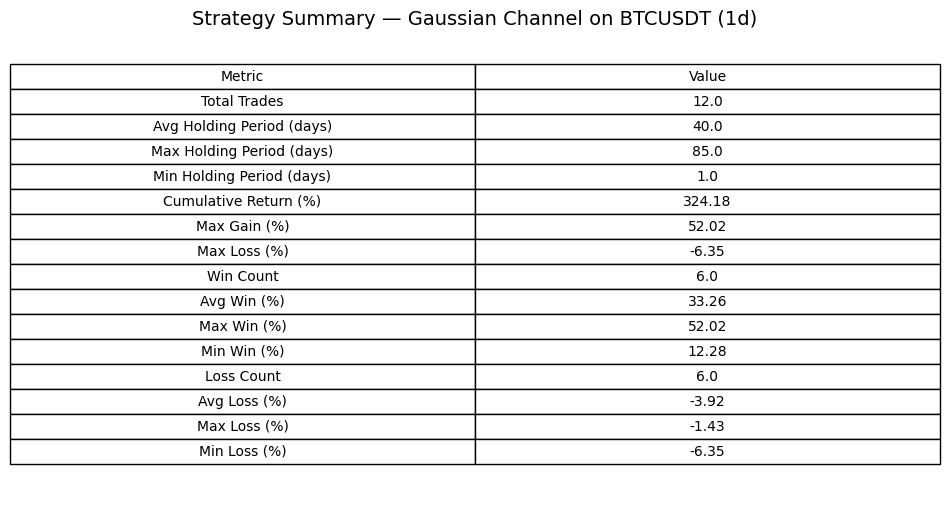

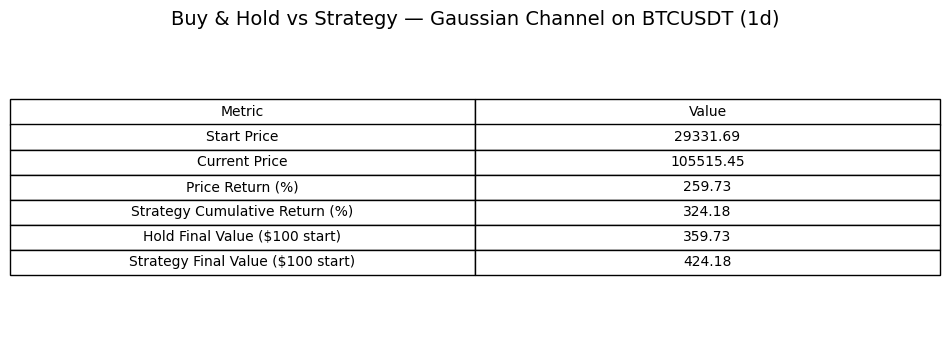

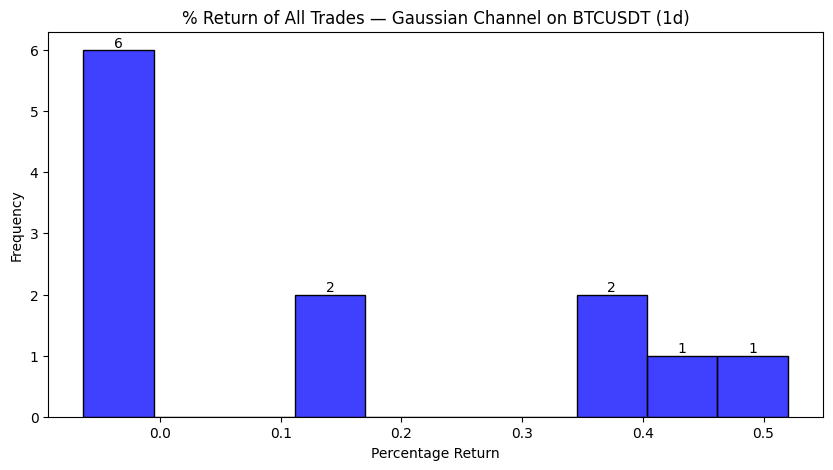

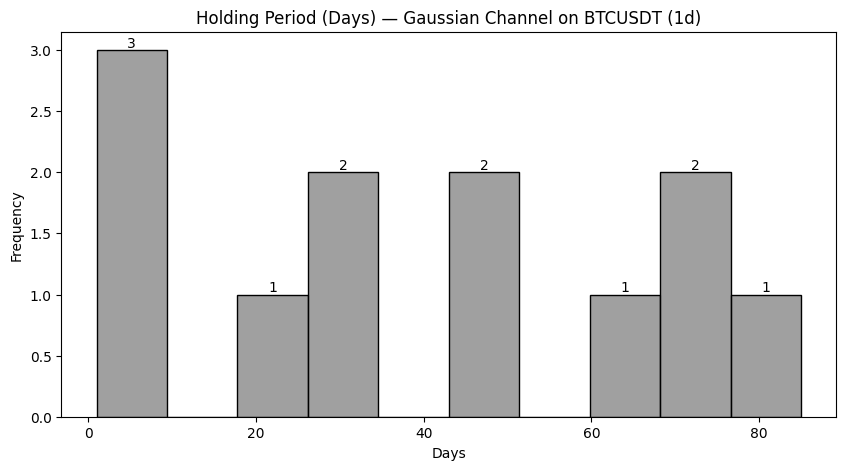

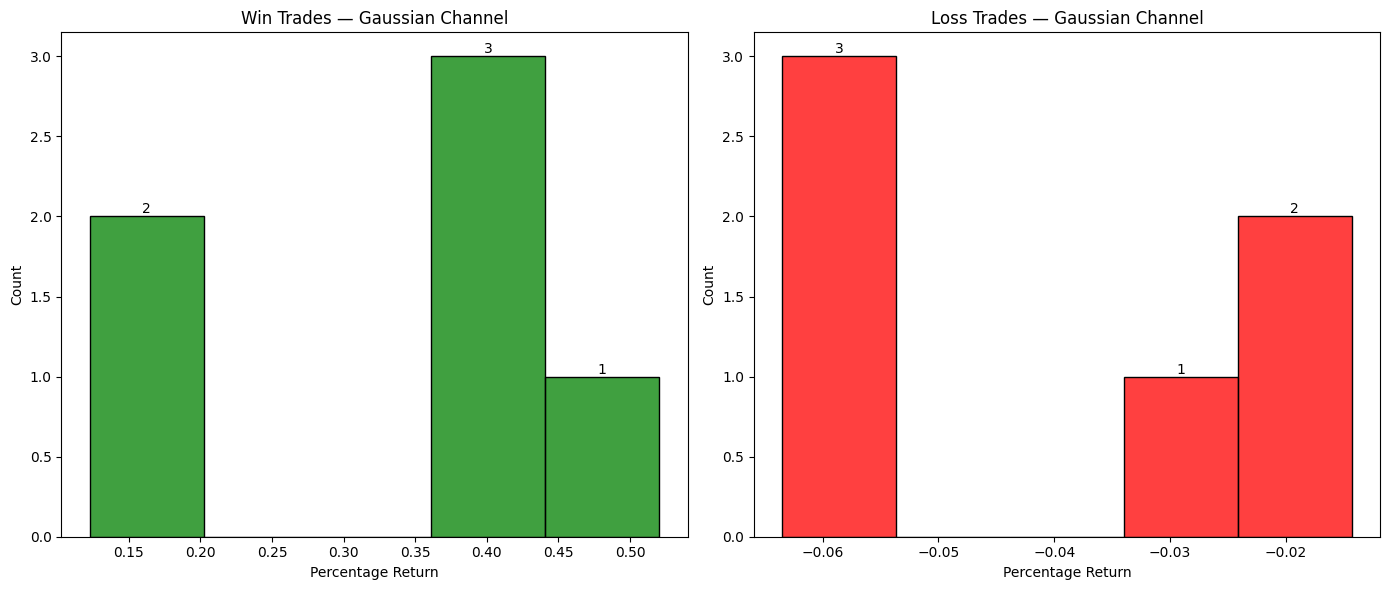

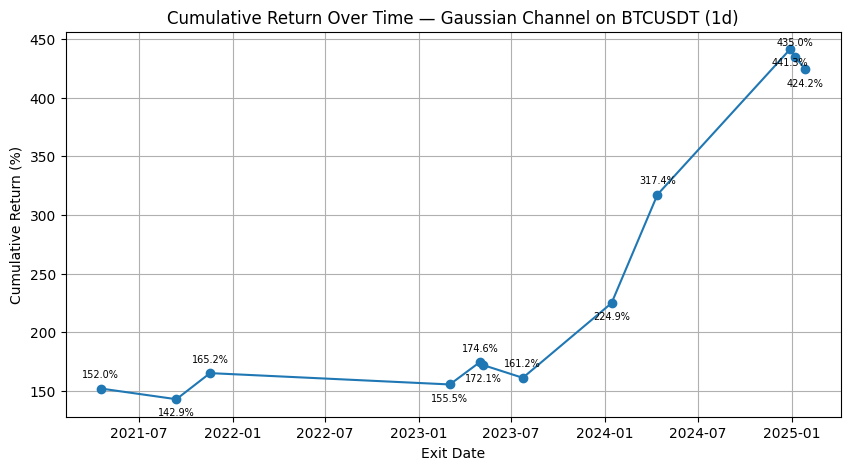


📈 Strategy Analysis for Gaussian Channel on ETHUSDT (1d) — 2025-06-03 21:49 UTC



/var/folders/mr/1dw7314j6b19b72p2nw5l2pc0000gn/T/ipykernel_13068/2440339603.py:200: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


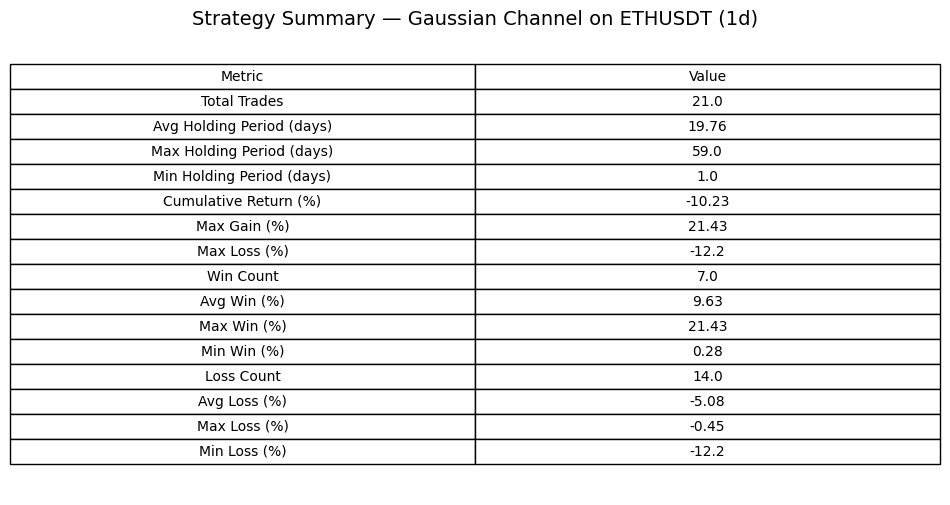

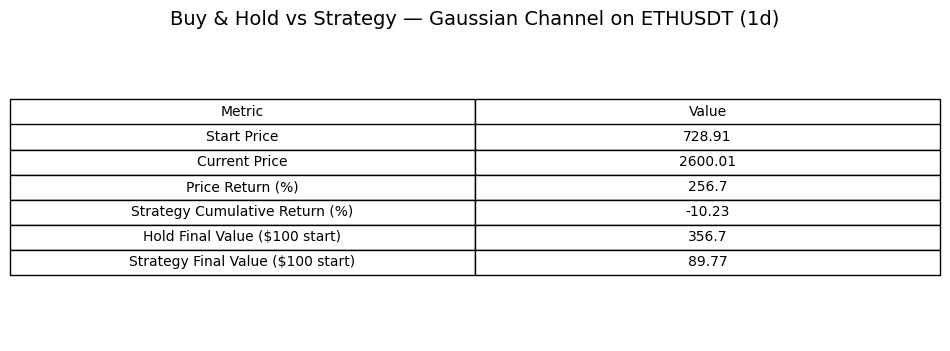

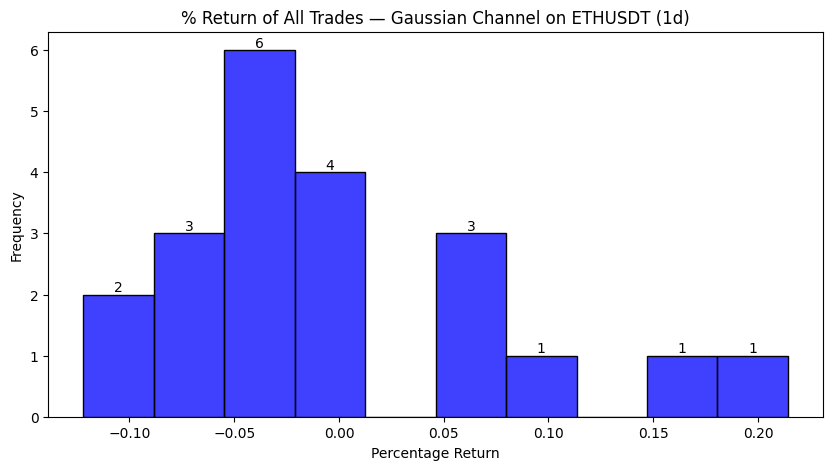

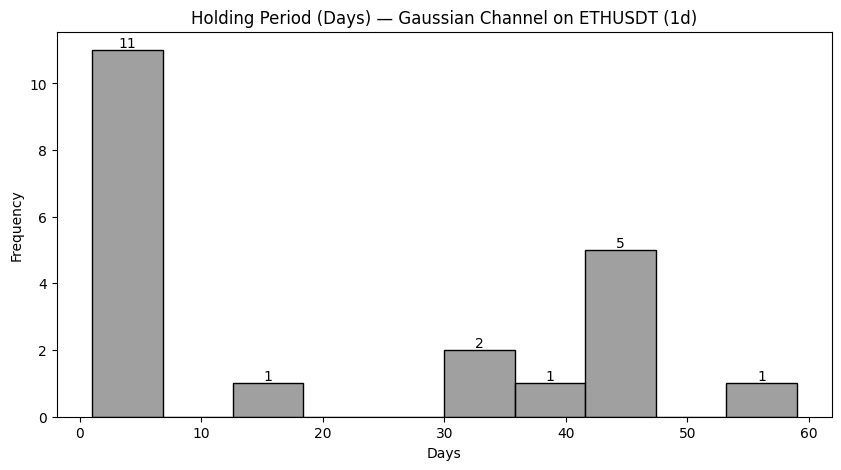

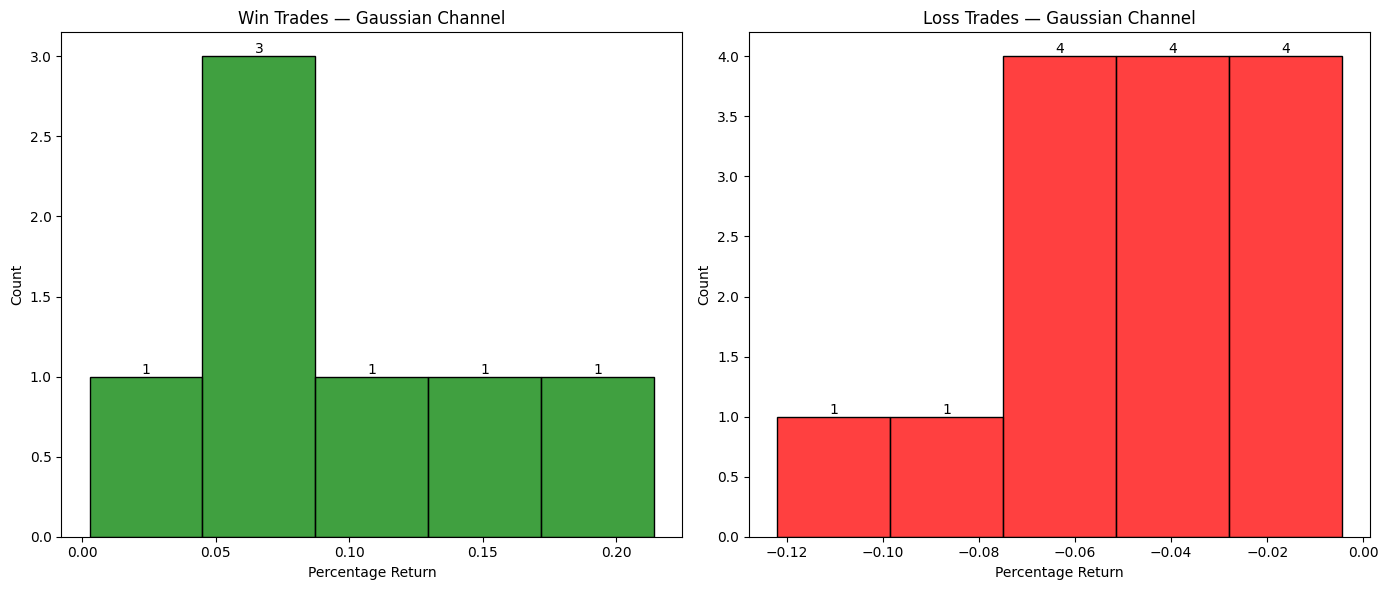

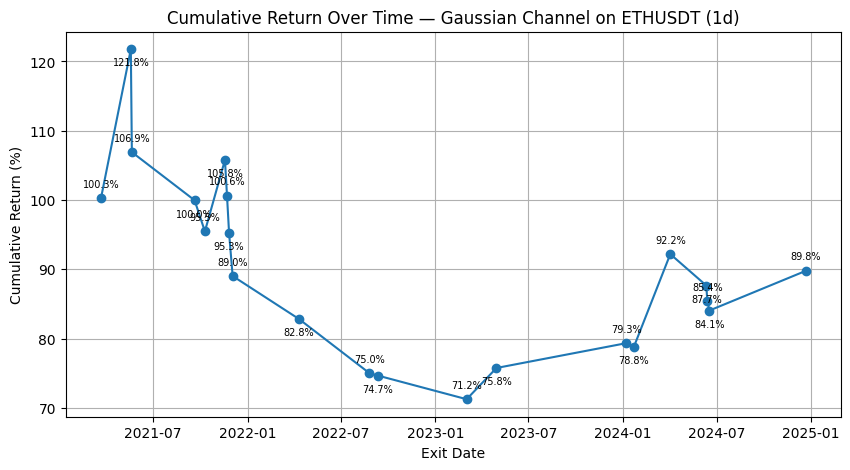

In [38]:
strategy_map = {
    "Gaussian Channel": {
        "function": gaussian_channel_strategy,
        "params": {
            "poles": 4,
            "per": 144,
            "mult": 1.414,
            "high_thr": 80,
            "low_thr": 20
        }
    },
    # "MACD": { "function": macd_strategy, "params": {...} }
}

symbols = ["BTCUSDT"
           #, "ETHUSDT"
           ]
intervals = ["1d"
             #, "4h"
             ]
all_signals = []

for strategy_name, strat_obj in strategy_map.items():
    for symbol in symbols:
        for interval in intervals:
            try:
                result = get_realtime_signal(
                    strategy_function=strat_obj["function"],
                    strategy_params=strat_obj["params"],
                    symbol=symbol,
                    interval=interval,
                    start_date="2021-01-01"
                )
                all_signals.append({
                    "strategy": strategy_name,
                    "symbol": symbol,
                    "interval": interval,
                    "signal": result["signal"]
                })

                # Show trade stats and plots
                analyze_trades(
                    trades_df=result["trades_df"],
                    df_prices=result["df"],  # this must include a 'close' column
                    symbol=result["symbol"],
                    strategy=result["strategy"],
                    interval=result["interval"]
                )
            except Exception as e:
                print(f"⚠️ Error running {strategy_name} on {symbol}-{interval}: {e}")

if all_signals:
    send_strategy_signals_email(all_signals)


#### Testeo estrategia con todos los cripto activos

In [40]:
# Required imports (only include if not already in your script)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# Define the test function
def test_strategy_on_symbols(strategy_function, strategy_params, symbols, interval="1d", start_date="2021-01-01"):
    results = []

    for symbol in symbols:
        try:
            result = get_realtime_signal(
                strategy_function=strategy_function,
                strategy_params=strategy_params,
                symbol=symbol,
                interval=interval,
                start_date=start_date
            )

            df_prices = result["df"]
            trades_df = result["trades_df"]

            if df_prices.empty or trades_df.empty:
                print(f"⚠️ Skipping {symbol} — No data.")
                continue

            # Calculate returns and simulated investment results
            start_price = df_prices["close"].iloc[0]
            end_price = df_prices["close"].iloc[-1]
            price_return = (end_price / start_price) - 1
            cumulative_return = np.prod(1 + trades_df["percentage_of_position"]) - 1
            initial_capital = 100
            hold_value = initial_capital * (1 + price_return)
            strategy_value = initial_capital * (1 + cumulative_return)

            results.append({
                "Symbol": symbol,
                "Start Price": round(start_price, 2),
                "Current Price": round(end_price, 2),
                "Price Return (%)": round(price_return * 100, 2),
                "Strategy Cumulative Return (%)": round(cumulative_return * 100, 2),
                "Hold Final Value ($100 start)": round(hold_value, 2),
                "Strategy Final Value ($100 start)": round(strategy_value, 2)
            })

        except Exception as e:
            print(f"❌ Error with {symbol}: {e}")
            continue

    return pd.DataFrame(results)

# Define the symbols to test
symbols = [
    "BTCUSDT", "ETHUSDT", "DOTUSDT", "SOLUSDT", "ADAUSDT", "DOGEUSDT",
    "XLMUSDT", "XRPUSDT", "ATOMUSDT", "LINKUSDT", "BNBUSDT", "LUNAUSDT"
]

# Define default parameters (as per your strategy)
strategy_params = {}  # using default hardcoded params in gaussian_channel_strategy

# Run the test
df_results = test_strategy_on_symbols(
    strategy_function=gaussian_channel_strategy,
    strategy_params=strategy_params,
    symbols=symbols,
    interval="1d",
    start_date="2021-01-01"
)
df_results

,Symbol,Start Price,Current Price,Price Return (%),Strategy Cumulative Return (%),Hold Final Value ($100 start),Strategy Final Value ($100 start)
0,BTCUSDT,29331.69,105464.85,259.56,324.18,359.56,424.18
1,ETHUSDT,728.91,2598.00,256.42,-10.23,356.42,89.77
2,DOTUSDT,8.28,4.16,-49.74,112.50,50.26,212.50
3,SOLUSDT,1.84,155.26,8328.42,6198.85,8428.42,6298.85
4,ADAUSDT,0.18,0.69,293.91,63.95,393.91,163.95
5,DOGEUSDT,0.01,0.19,3310.92,761.67,3410.92,861.67
6,XLMUSDT,0.13,0.27,106.94,-45.94,206.94,54.06
7,XRPUSDT,0.24,2.24,844.79,-69.78,944.79,30.22
8,ATOMUSDT,5.86,4.43,-24.47,8.61,75.53,108.61
9,LINKUSDT,11.85,14.19,19.77,-22.50,119.77,77.50


In [ ]:
#Activos con mejor rendimiento en dicha estrategia:
crypto_symbols = ['BTCUSDT', 'SOLUSDT', 'DOGEUSDT', 'BNBUSDT', 'LUNAUSDT']